## Recreating Smoothed Collocation in Python based on Julia libraries
based on:
* https://docs.sciml.ai/DiffEqFlux/stable/examples/collocation/
* https://github.com/SciML/DiffEqFlux.jl/blob/master/src/collocation.jl

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve

### `Initial Simplified Attempt`

In [223]:
def true_ode_func(t, u):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    return true_A.dot(u**3)

u0 = np.array([2.0, 0.0], dtype=np.float32)
tspan = (0.0, 1.5)
tsteps = np.linspace(*tspan, num=300)
print(tsteps.shape)

sol = solve_ivp(true_ode_func, tspan, u0, t_eval=tsteps, method='RK45')
print(sol)
true_data = sol.y

# NOISY DATA
data = sol.y + 0.1 * np.random.randn(*sol.y.shape)
print(data.shape)
print(data)

(300,)
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.017e-03 ...  1.495e+00  1.500e+00]
        y: [[ 2.000e+00  1.996e+00 ...  1.303e+00  1.293e+00]
            [ 0.000e+00 -8.003e-02 ... -9.487e-01 -9.702e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 128
     njev: 0
      nlu: 0
(2, 300)
[[ 1.96067606e+00  1.96832462e+00  1.88964443e+00  1.96436659e+00
   1.85224753e+00  2.11224665e+00  2.07610901e+00  1.92132001e+00
   1.88834613e+00  1.94889724e+00  1.93441405e+00  1.74357499e+00
   1.97675784e+00  1.91233185e+00  2.07671293e+00  1.91483048e+00
   1.92064702e+00  2.00463512e+00  1.80654437e+00  1.78418782e+00
   1.77576576e+00  1.71363119e+00  1.78904064e+00  1.48886572e+00
   1.51309132e+00  1.64068917e+00  1.46373264e+00  1.52311652e+00
   1.53161303e+00  1.29511320e+00  1.28174137e+00  1.28378745e+00
   1.17258362e+00  1.19194831e+00  1.09175635e+00  1.05889080e+00
   9.4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


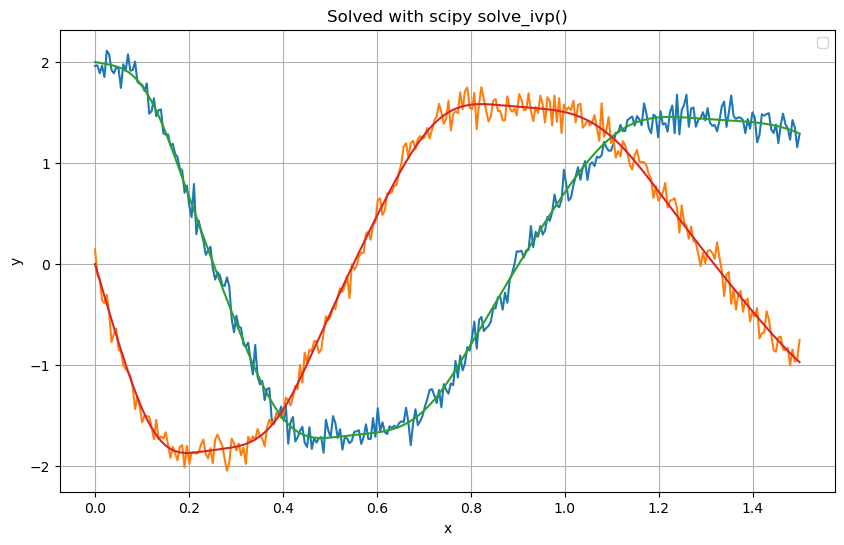

In [224]:
plt.figure(figsize=(10, 6))
plt.plot(tsteps, data[0])
plt.plot(tsteps, data[1])
plt.plot(tsteps, true_data[0])
plt.plot(tsteps, true_data[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solved with scipy solve_ivp()')
plt.legend()
plt.grid(True)
plt.show()

In [225]:
# define kernels
def calckernel(kernel, t):
    abst = abs(t)
    if abst > 1:
        return 0
    return kernel_dict[kernel](t, abst)

def triangular_kernel(t, abst):
    return 1 - abst

def epanechnikov_kernel(t, abst):
    return 0.75 * (1 - t**2)

kernel_dict = {
    'EpanechnikovKernel': epanechnikov_kernel,
    'TriangularKernel': triangular_kernel,
}

In [226]:
def collocate_data(data, tpoints, kernel='EpanechnikovKernel', bandwidth=None):
    n = len(tpoints)
    
#------------------------------------BANDWIDTH-----------------------------------#
    if bandwidth is None:
        bandwidth = n**(-1/5) * n**(-3/35) * (np.log(n))**(-1/16)
        print('Bandwidth:', bandwidth)

    estimated_solution = np.zeros_like(data)
    data = data.T

    for i, t in enumerate(tpoints):
#--------------------------------KERNEL WEIGHTS--------------------------------#
        # computes the weights for each point in tpoints
        weights = np.array([calckernel(kernel, (tp - t) / bandwidth) for tp in tpoints])
        W = np.diag(weights)

#----------------------------------CONSTRUCT MATRIX----------------------------#
        # second column is the differences between target points and the current point
        A = np.vstack([np.ones_like(tpoints), tpoints - t]).T
        
#------------------------APPLY WEIGHTS TO THE MATRIX---------------------------#
        A_weighted = W @ A
        
        # iterate over each variable
        for var in range(data.shape[1]):
            # weighted target vector for the current variable
            b = W @ data[:, var]
            # Before solving the linear system, this check ensures that the matrix A_weighted is not singular 
            if np.linalg.matrix_rank(A_weighted) < A_weighted.shape[1]:
                continue  # skip if A_weighted is singular
            # solve the Weighted Least Squares Problem
            solution = solve(A_weighted.T @ A_weighted, A_weighted.T @ b) # (A^T * W * A)^-1 * A^T * W * b
            # stores the intercept (the constant term of the regression model) in the output matrix
            estimated_solution[var, i] = solution[0] 

    return estimated_solution  


* fit a linear model to each variable, using weights to adjust for the importance or relevance of each data point

In [227]:
#-------------------------------------NODE SET UP----------------------------------#
#-----------------------------------DATA GENERATION--------------------------------#
#------------------------------------COLLOCATION MATRIX----------------------------#
#-----------------------------------MODEL CREATION---------------------------------#
#---------------------------------NEURAL NET PARAMS--------------------------------#
#-----------------------------------FORWARD PASS-----------------------------------#
#--------------------------------INITIAL CONDITIONS--------------------------------#
#------------------------------------CONSTRAINTS-----------------------------------#
#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
#--------------------------------SOLVING THE MODEL---------------------------------#


### `Improved Approach`

In [228]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve
from jax.experimental.ode import odeint

In [229]:
#-----------------------------------TRUE ODE--------------------------------#

def true_ode_func(u, t, true_A):
    return true_A.dot(u**3)

#-----------------------------------DATA GENERATION--------------------------------#

u0 = jnp.array([2.0, 0.0], dtype=jnp.float32)
tspan = (0.0, 1.5)
tsteps = jnp.linspace(*tspan, num=300)

print(tsteps.shape)

# Define the true_A matrix
true_A = jnp.array([[-0.1, 2.0], [-2.0, -0.1]], dtype=jnp.float32)

sol = odeint(true_ode_func, u0, tsteps, true_A)

# print(sol)
true_data = sol

#-----------------------------------NOISE--------------------------------#
key = jax.random.PRNGKey(0)
noise = 0.1 * jax.random.normal(key, shape=sol.shape)
data = sol + noise

print(data.shape)
# print(data)

(300,)
(300, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


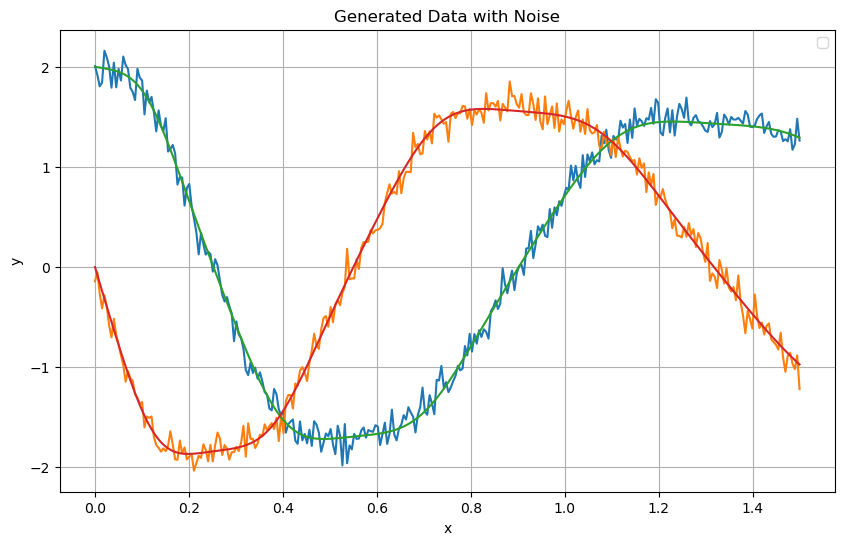

In [230]:
plt.figure(figsize=(10, 6))
plt.plot(tsteps, data.T[0])
plt.plot(tsteps, data.T[1])
plt.plot(tsteps, true_data.T[0])
plt.plot(tsteps, true_data.T[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data with Noise')
plt.legend()
plt.grid(True)
plt.show()

In [231]:
#-----------------------------------COLLOCATION FUNCTIONS--------------------------------#

def construct_t_matrix(order, tpoints, t):
    """
    Constructs the T matrix for collocation.

    Args:
        order (int): The order of the T matrix (1 or 2).
        tpoints (jax.numpy.ndarray): The array of time points.
        t (float): The current time point.

    Returns:
        jax.numpy.ndarray: The constructed T matrix.
    """
    if order == 1:
        return jnp.vstack([jnp.ones_like(tpoints), tpoints - t]).T
    elif order == 2:
        return jnp.vstack([jnp.ones_like(tpoints), tpoints - t, (tpoints - t)**2]).T

def construct_w(tpoints, t, bandwidth, kernel_type):
    """
    Constructs the weight matrix W for collocation.

    Args:
        tpoints (jax.numpy.ndarray): The array of time points.
        t (float): The current time point.
        bandwidth (float): The bandwidth for the kernel.
        kernel_type (str): The type of kernel to use ("TriangularKernel" or "EpanechnikovKernel").

    Returns:
        jax.numpy.ndarray: The diagonal weight matrix W.
    """
    return jnp.diag(jax.vmap(lambda tp: calckernel(kernel_type, (tp - t) / bandwidth))(tpoints))

def calckernel(kernel_type, x):
    """
    Calculates the kernel value.

    Args:
        kernel_type (str): The type of kernel to use ("TriangularKernel" or "EpanechnikovKernel").
        x (float): The input value for the kernel function.

    Returns:
        float: The calculated kernel value.
    """
    if kernel_type == "TriangularKernel":
        return jnp.maximum((1 - jnp.abs(x)), 0)
    elif kernel_type == "EpanechnikovKernel":
        return (3/4) * jnp.maximum((1 - x**2), 0)
    
def configure_extraction_vectors(data):
    """
    Configures the extraction vectors e1 and e2.

    Args:
        data (jax.numpy.ndarray): The data array to infer the shape.

    Returns:
        tuple: The extraction vectors e1 and e2.
    """
    _one = 1.0
    _zero = 0.0

    # To extract the constant term (intercept)
    e1 = jnp.array([[_one, _zero]]).T  
    # To extract the linear term and optionally the quadratic term
    e2 = jnp.array([[_zero, _one, _zero]]).T 
    
    return e1, e2

In [232]:
from jax.numpy.linalg import solve, inv

In [233]:
def collocate_data(data, tpoints, kernel="TriangularKernel", bandwidth=None):
    """
    Applies the kernel-based collocation method to smooth data.

    Args:
        data (jax.numpy.ndarray): The noisy data array.
        tpoints (jax.numpy.ndarray): The array of time points.
        kernel (str, optional): The type of kernel to use. Defaults to "TriangularKernel".
        bandwidth (float, optional): The bandwidth for the kernel. If None, it is calculated automatically. Defaults to None.

    Returns:
        tuple: The estimated derivatives and smoothed solutions.
    """
    n = len(tpoints)

    # the exprected shape is (dimensions, no of datapoints)
    # hence, the number of datapoints should be larger than the number of dimensions
    if data.shape[0] > data.shape[1]:
        data = data.T
#-----------------------------------BANDWIDTH----------------------------------#
    if bandwidth is None:
        bandwidth = (n**(-1/5)) * (n**(-3/35)) * (jnp.log(n)**(-1/16))
    
    # M = construct_t_matrix(2, tpoints, 0)

#-------------------------COEFFICIENT EXTRACTION VECTORS------------------------#
    # later on used to extract  coefficients from local polynomial approximations
    e1, e2 = configure_extraction_vectors(data[:, 0])

    # print(e2.shape)
    estimated_solution = []
    estimated_derivative = []

    for _t in tpoints:
#-----------------------------MATRIX CONSTRUCTION--------------------------------#
        # constructs the first-order T matrix
        T1 = construct_t_matrix(1, tpoints, _t)
        # constructs the second-order T matrix
        T2 = construct_t_matrix(2, tpoints, _t)
        # constructs the weight matrix
        W = construct_w(tpoints, _t, bandwidth, kernel)
        # print(W)
#-----------------------------------WEIGHT DATA-----------------------------------#
        # print(W.shape)
        # print(data.T.shape)
        Wd = W @ data.T
        # return 0, 0

#---------------------------------WEIGHT T-MATRICES-------------------------------#
        WT1 = W @ T1
        WT2 = W @ T2
        
        # form matrices for the least-squares weighted quadratic fitting problem
        T1WT1 = T1.T @ WT1
        T2WT2 = T2.T @ WT2
#---------------------------------------------------------------------------------#
#                           Solve (T1^T W T1 c1) = T1^T W y 
#---------------------------------------------------------------------------------#

#-----------------------------------INVERSE--------------------------------------#
        # inv_T1WT1 = jnp.linalg.inv(T1WT1)
        # inv_T2WT2 = jnp.linalg.inv(T2WT2)

#------------------------------EXTRACT COEFFICIENTS------------------------------#
        """ 
        Solution through matrix inversion,
        but somet
        inv_T1WT1 = inv(T1WT1)
        solution1 = inv_T1WT1 @ (T1.T @ Wd)
        result_solution = e1.T @ solution1
        estimated_solution.append(result_solution)
        
       
        inv_T2WT2 = inv(T2WT2)
        solution2 = inv_T2WT2 @ (T2.T @ Wd)
        result_derivative = e2.T @ solution2
        estimated_derivative.append(result_derivative)
        
        estimated_solution_stacked = jnp.stack(estimated_solution).T
        estimated_derivative_stacked = jnp.stack(estimated_derivative).T

    return estimated_solution_stacked, estimated_derivative_stacked"""

        solution1 = solve(T1WT1, T1.T @ Wd)
        result_solution = e1.T @ solution1
        result_solution = jnp.squeeze(result_solution) # remove extra dimension
        estimated_solution.append(result_solution)
        
        solution2 = solve(T2WT2, T2.T @ Wd)
        result_derivative = (e2.T @ solution2)
        result_derivative = jnp.squeeze(result_derivative) # remove extra dimension
        estimated_derivative.append(result_derivative)
        # print(result_derivative)
        
        estimated_solution_ = jnp.stack(estimated_solution).T
        estimated_derivative_ = jnp.stack(estimated_derivative).T

    return estimated_derivative_, estimated_solution_
    

In [234]:
#-----------------------------------APPLYING COLLOCATION--------------------------------#

estimated_derivative, estimated_solution = collocate_data(data, tsteps, kernel="EpanechnikovKernel", bandwidth=None)

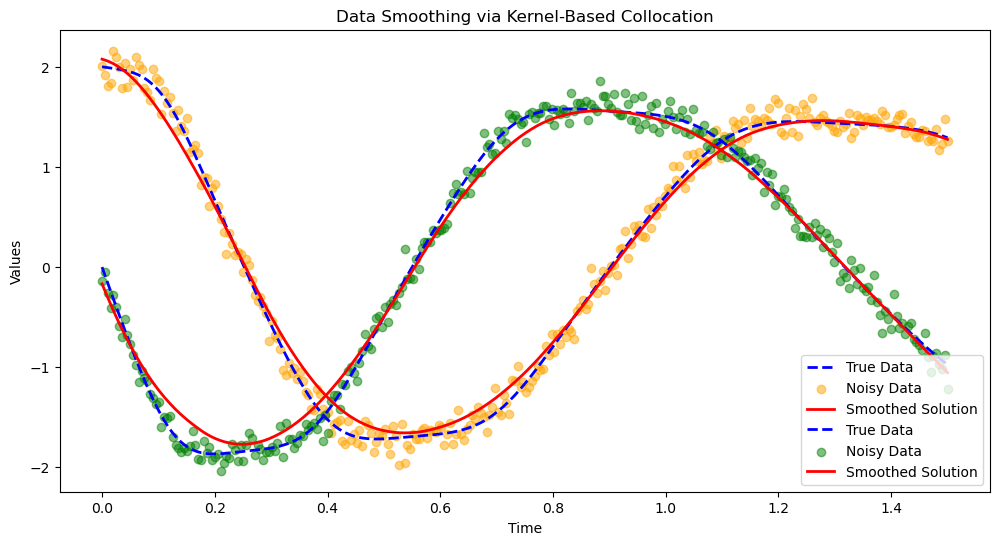

In [235]:
#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 6))
plt.plot(tsteps, true_data[:, 0], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 0], color='orange', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[0], 'r-', linewidth=2, label='Smoothed Solution')

plt.plot(tsteps, true_data[:, 1], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 1], color='green', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[1], 'r-', linewidth=2, label='Smoothed Solution')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

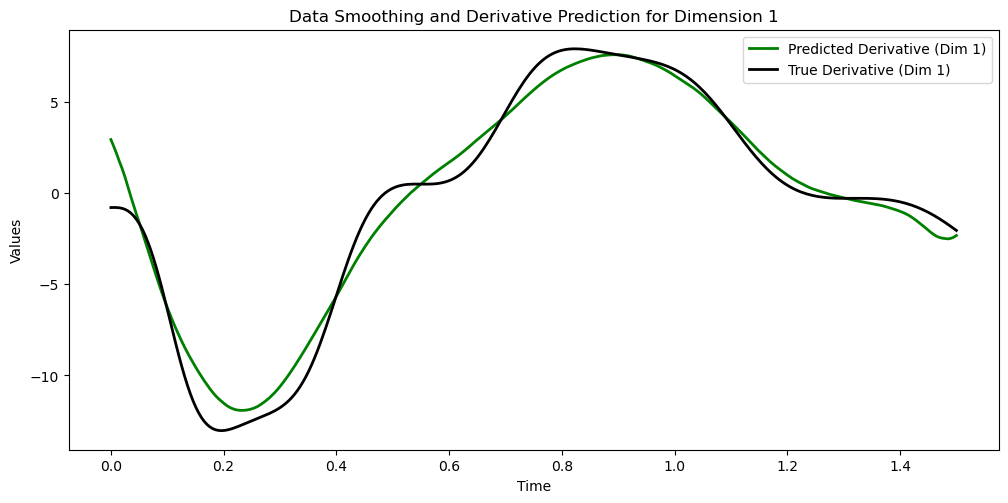

In [236]:
#-----------------------------------TRUE DERIVATIVES--------------------------------#
true_derivatives = jnp.array([true_ode_func(u, t, true_A) for u, t in zip(true_data, tsteps)])

#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 12))

# Plot for the first dimension
plt.subplot(2, 1, 1)
plt.plot(tsteps, estimated_derivative[0], 'g-', linewidth=2, label='Predicted Derivative (Dim 1)')
plt.plot(tsteps, true_derivatives[:, 0], 'k-', linewidth=2, label='True Derivative (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing and Derivative Prediction for Dimension 1')
plt.legend()
plt.show()

In [237]:
equally_spaced_points_loss = jnp.sum(jnp.abs(estimated_derivative[0] - true_derivatives[:, 0]))

In [238]:
equally_spaced_points_loss

Array(221.03445, dtype=float32)

## Plot the true vs predicted derivative

`1.` What impact the spacing would have? <br>
`2.` How does this compare to cubic spline smoothing? <br>
`3.` What parameters could we control to make it more accurate?

### `1` Chebyshev Node Spacing

In [239]:
from interpolation import BarycentricInterpolation

In [240]:
#-----------------------------------TRUE ODE--------------------------------#

def true_ode_func(u, t, true_A):
    return true_A.dot(u**3)

#-----------------------------------DATA GENERATION--------------------------------#

u0 = jnp.array([2.0, 0.0], dtype=jnp.float32)
tspan = (0.0, 1.5)
N = 200 
interpolator = BarycentricInterpolation(N, tspan[0], tspan[1])
tsteps = interpolator.nodes

print(tsteps.shape)

# Define the true_A matrix
true_A = jnp.array([[-0.1, 2.0], [-2.0, -0.1]], dtype=jnp.float32)

sol = odeint(true_ode_func, u0, tsteps, true_A)

# print(sol)
true_data = sol

#-----------------------------------NOISE--------------------------------#
key = jax.random.PRNGKey(0)
noise = 0.1 * jax.random.normal(key, shape=sol.shape)
data = sol + noise

print(data.shape)

#-----------------------------------APPLYING COLLOCATION--------------------------------#

estimated_derivative, estimated_solution = collocate_data(data, tsteps, kernel="EpanechnikovKernel", bandwidth=None)

(200,)
(200, 2)


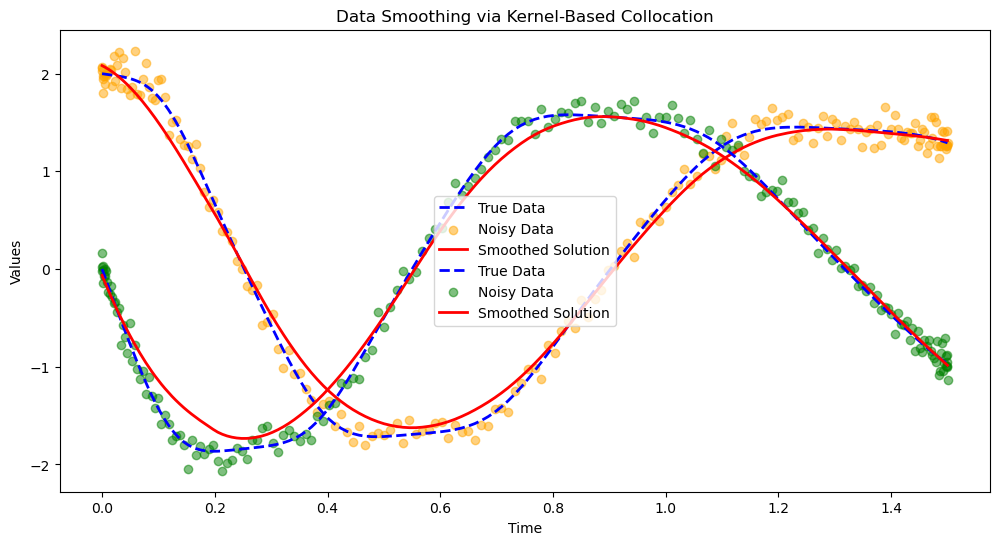

In [241]:
#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 6))
plt.plot(tsteps, true_data[:, 0], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 0], color='orange', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[0], 'r-', linewidth=2, label='Smoothed Solution')

plt.plot(tsteps, true_data[:, 1], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 1], color='green', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[1], 'r-', linewidth=2, label='Smoothed Solution')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

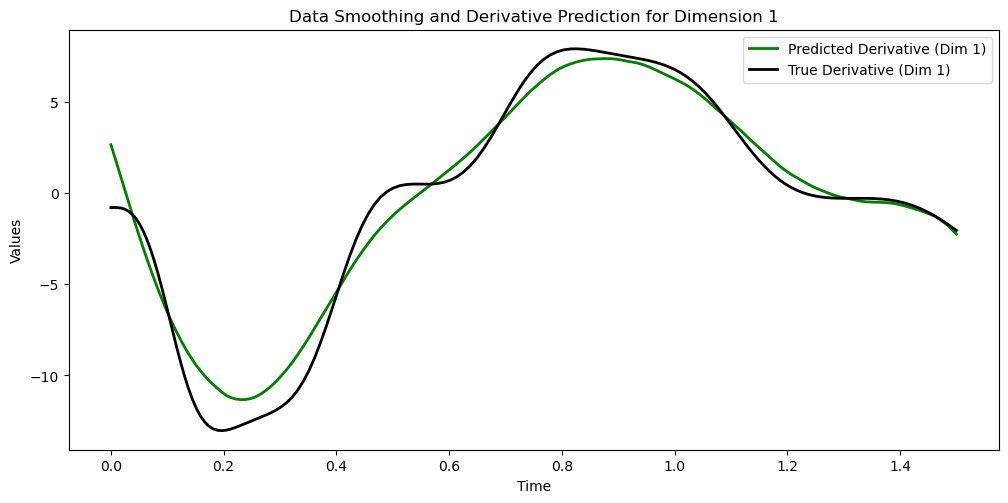

In [242]:
#-----------------------------------TRUE DERIVATIVES--------------------------------#
true_derivatives = jnp.array([true_ode_func(u, t, true_A) for u, t in zip(true_data, tsteps)])

#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 12))

# Plot for the first dimension
plt.subplot(2, 1, 1)
plt.plot(tsteps, estimated_derivative[0], 'g-', linewidth=2, label='Predicted Derivative (Dim 1)')
plt.plot(tsteps, true_derivatives[:, 0], 'k-', linewidth=2, label='True Derivative (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing and Derivative Prediction for Dimension 1')
plt.legend()

In [243]:
chebyshev_nodes_loss = jnp.sum(jnp.abs(estimated_derivative[0] - true_derivatives[:, 0]))
print(f'Chebyshev nodes loss: {chebyshev_nodes_loss:.2f}')
print(f'Equally spaced points loss {equally_spaced_points_loss:.2f}')

Chebyshev nodes loss: 169.23
Equally spaced points loss 221.03


### `2.` Cubic Spline Smoothing

In [175]:
from scipy.interpolate import CubicSpline

def cubic_spline_approximation(t, data, num_points):
    """
    Generate interpolation points and corresponding derivatives using cubic splines.
    Args:
        t (array-like of shape (n,)): time points at which the original data is sampled.
        data (array-like of shape (n,) or (n, m)): data points.
        num_points (int): number of interpolation points to generate.

    Returns:
        interpolation_t (ndarray of shape (num_points,)): array of evenly spaced interpolation time points.
        interpolation_data (ndarray of shape (num_points,) or (num_points, m)): interpolated data values at the interpolation points.
        interpolation_derivative (ndarray of shape (num_points,) or (num_points, m)): first derivatives of the interpolated data at the interpolation points.
    """
    # Fit cubic spline to data
    spline = CubicSpline(t, data)
    # Generate interpolation points
    interpolation_t = np.linspace(t[0], t[-1], num_points)
    # Evaluate spline at interpolation points
    interpolation_data = spline(interpolation_t)
    # Evaluate derivative of spline at interpolation points
    interpolation_derivative = spline(interpolation_t, 1)
    return interpolation_t, interpolation_data.T, interpolation_derivative.T

In [176]:
#-----------------------------------TRUE ODE--------------------------------#
def true_ode_func(u, t, true_A):
    return true_A.dot(u**3)

#-----------------------------------DATA GENERATION--------------------------------#

u0 = jnp.array([2.0, 0.0], dtype=jnp.float32)
tspan = (0.0, 1.5)
N = 50
tsteps = jnp.linspace(*tspan, num=N)

print(tsteps.shape)

true_A = jnp.array([[-0.1, 2.0], [-2.0, -0.1]], dtype=jnp.float32)

true_data = odeint(true_ode_func, u0, tsteps, true_A)

#-----------------------------------NOISE--------------------------------#
key = jax.random.PRNGKey(0)
noise = 0.1 * jax.random.normal(key, shape=true_data.shape)
data = true_data + noise

interpolation_t, interpolation_data, interpolation_derivative = cubic_spline_approximation(tsteps, data, 300)

(50,)


In [177]:
#-----------------------------------APPLY CUBIC SPLINE APPROXIMATION--------------------------------#
interpolation_t, interpolation_data, interpolation_derivative = cubic_spline_approximation(tsteps, data, N)

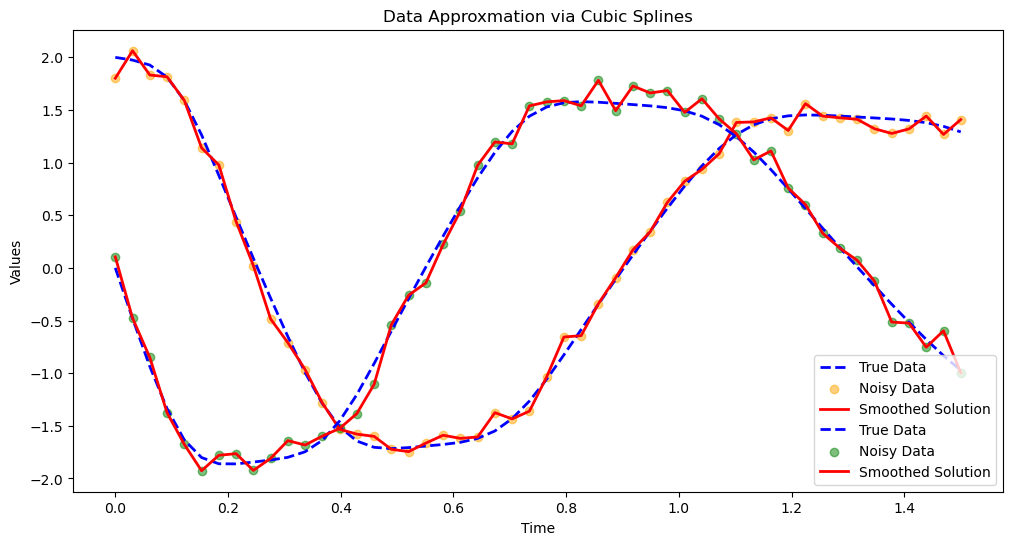

In [178]:
#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 6))
plt.plot(tsteps, true_data[:, 0], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 0], color='orange', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, interpolation_data[0], 'r-', linewidth=2, label='Smoothed Solution')

plt.plot(tsteps, true_data[:, 1], 'b--', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 1], color='green', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, interpolation_data[1], 'r-', linewidth=2, label='Smoothed Solution')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Approxmation via Cubic Splines')
plt.legend()
plt.show()

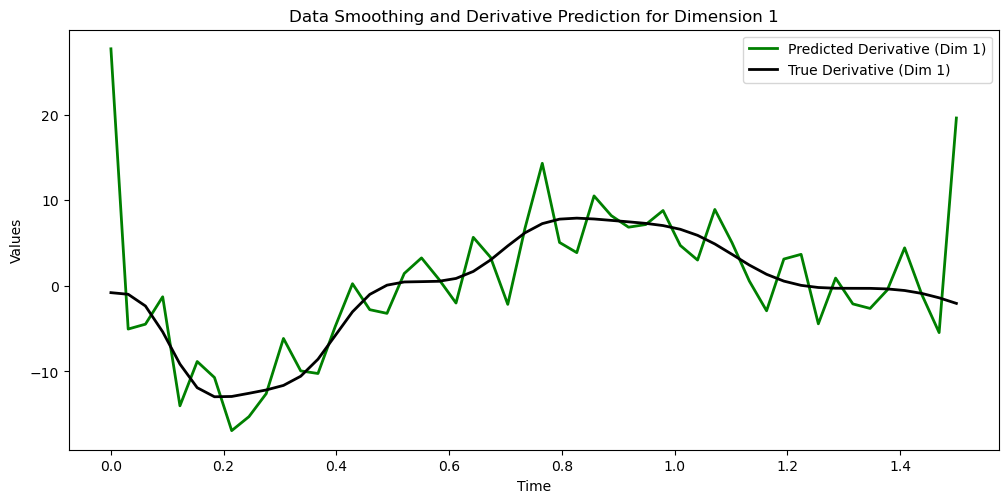

In [165]:
#-----------------------------------TRUE DERIVATIVES--------------------------------#
true_derivatives = jnp.array([true_ode_func(u, t, true_A) for u, t in zip(true_data, tsteps)])

#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 12))

# Plot for the first dimension
plt.subplot(2, 1, 1)
plt.plot(interpolation_t, interpolation_derivative[0], 'g-', linewidth=2, label='Predicted Derivative (Dim 1)')
plt.plot(tsteps, true_derivatives[:, 0], 'k-', linewidth=2, label='True Derivative (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing and Derivative Prediction for Dimension 1')
plt.legend()

## Damped Oscillation

In [34]:
from interpolation import BarycentricInterpolation

In [43]:
def odes(t, y):
    X, Y = y
    dXdt = -0.1 * X**3 - 2 * Y**3
    dYdt = 2 * X**3 - 0.1 * Y**3
    return [dXdt, dYdt]


u0 = [1.0, 1.0]  
tspan = (0, 10) 
tsteps = np.linspace(*tspan, 500) 
# tsteps = interpolator.nodes

sol = solve_ivp(odes, tspan, u0, t_eval=tsteps, method='RK45')
true_data = sol.y

# noisy
noisy_data = true_data + 0.1 * np.random.randn(*true_data.shape)

## Equally Spaced Points

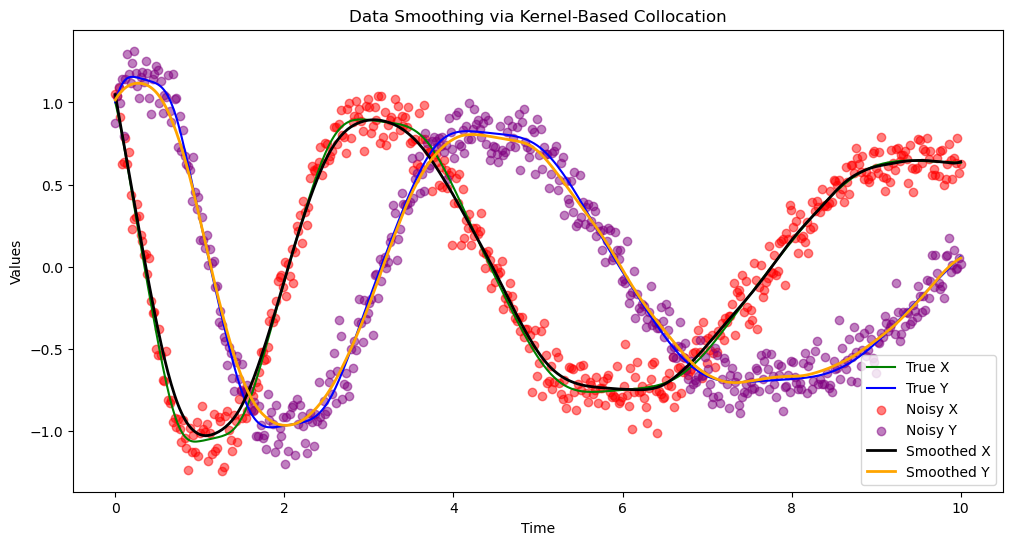

In [44]:
smoothed_data = collocate_data(noisy_data, tsteps, kernel='EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(12, 6))

plt.plot(tsteps, true_data[0], 'g-', label='True X')
plt.plot(tsteps, true_data[1], 'b-', label='True Y')

plt.scatter(tsteps, noisy_data[0], color='red', alpha=0.5, label='Noisy X')
plt.scatter(tsteps, noisy_data[1], color='purple', alpha=0.5, label='Noisy Y')

plt.plot(tsteps, smoothed_data[0], 'k-', label='Smoothed X', linewidth=2)
plt.plot(tsteps, smoothed_data[1], 'orange', label='Smoothed Y', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

## Chebyshev Nodes

In [ ]:
def odes(t, y):
    X, Y = y
    dXdt = -0.1 * X**3 - 2 * Y**3
    dYdt = 2 * X**3 - 0.1 * Y**3
    return [dXdt, dYdt]


u0 = [1.0, 1.0]  
tspan = (0, 10) 
# tsteps = np.linspace(*tspan, 500) 

interpolator = BarycentricInterpolation(500, 0, 10)
tsteps = interpolator.nodes

sol = solve_ivp(odes, tspan, u0, t_eval=tsteps, method='RK45')
true_data = sol.y

# noisy
noisy_data = true_data + 0.1 * np.random.randn(*true_data.shape)

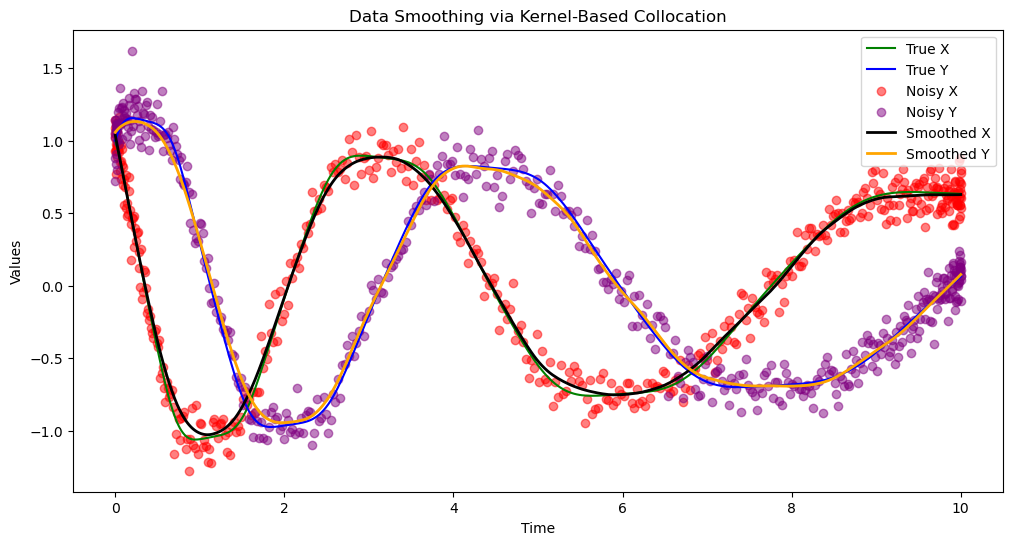

In [41]:
smoothed_data = collocate_data(noisy_data, tsteps, kernel='EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(12, 6))

plt.plot(tsteps, true_data[0], 'g-', label='True X')
plt.plot(tsteps, true_data[1], 'b-', label='True Y')

plt.scatter(tsteps, noisy_data[0], color='red', alpha=0.5, label='Noisy X')
plt.scatter(tsteps, noisy_data[1], color='purple', alpha=0.5, label='Noisy Y')

plt.plot(tsteps, smoothed_data[0], 'k-', label='Smoothed X', linewidth=2)
plt.plot(tsteps, smoothed_data[1], 'orange', label='Smoothed Y', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()